# Interactive Recommendation System with Word Embeddings using Word2Vec, Plotly, and NetworkX
Here, We will be exploring how to build a model that can understand words in a mathematical way, such that words with similar meaninings that share certain charactertics belong close to each other in vector space. That's a fancy way of saying that the mathemical representations for words that have some similar meaning are close to each other, and words that don't share a lot of meaning are further apart. We will show that this model can be adapted to be used in a recommendation system, or as a discovery tool (i.e. we don't have this in stock, maybe you'd like this alternative?).

## 1. Introduction
We will be using a recipe dataset, to train a model to learn the interactions between different kind of ingredients and available products in a supermarket. This model can then be implemented in a number of different ways, for example,
- to recommend products based on items added to cart;
- to offer alternatives products based on stock;
- to discover new products to create different recipes.


### Sample
*Herb Rubbed Sirloin Tip Roast*

- 1 1/4 tablespoons paprika
- 1 tablespoon kosher salt
- 1 teaspoon garlic powder
- 1/2 teaspoon ground black pepper
- 1/2 teaspoon onion powder
- 1/2 teaspoon ground cayenne pepper
- 1/2 teaspoon dried oregano
- 1/2 teaspoon dried thyme
- 2 tablespoons olive oil
- 1 (3 pound) sirloin tip roast

In a small bowl, mix the paprika, kosher salt, garlic powder, black pepper, onion powder, cayenne pepper, oregano, and thyme. Stir in the olive oil, and allow the mixture to sit about 15 minutes.

Preheat oven to 350 degrees F (175 degrees C). Line a baking sheet with aluminum foil.

Place the roast on the prepared baking sheet, and cover on all sides with the spice mixture.

Roast 1 hour in the preheated oven, or to a minimum internal temperature of 145 degrees F (63 degrees C). Let sit 15 minutes before slicing.

## 2. Exploratory Data Analysis and Preprocessing

[This is the dataset](https://eightportions.com/datasets/Recipes/#fn:1) we will be using. It is collated by Ryan Lee, sourced from [Food Network](https://www.foodnetwork.com/), [Epicurious](https://www.epicurious.com/), and [Allrecipes](https://www.allrecipes.com/).

In [1]:
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
import pandas as pd
import pickle
import string
import json

C:\Users\KIIT\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
recipe_sources = ['ar', 'epi', 'fn']

In [3]:
df = pd.DataFrame()
sources, titles, ingredients, instructions = [], [], [], []
for recipe_source in recipe_sources:
    data = json.load(open(f'Data/Dataset/recipes_raw_nosource_{recipe_source}.json', 'r'))
    for _, recipe in data.items():
        if ('title' in recipe) and ('ingredients' in recipe) and ('instructions' in recipe):
            sources.append(recipe_source)
            titles.append(recipe['title'])
            ingredients.append([str(ingredient).replace('ADVERTISEMENT', '') for ingredient in recipe['ingredients']])
            instructions.append(str(recipe['instructions']).replace('ADVERTISEMENT', '').replace('\n', ' '))
            
df['source'] = sources
df['title'] = titles
df['ingredients'] = ingredients
df['instructions'] = instructions

In [4]:
to_remove = [
    'tablespoon',
    'tablespoons',
    'teaspoon',
    'teaspoons',
    'tsp',
    'tsps',
    'tbsp',
    'tbsps',
    'pound',
    'pounds',
    'grams',
    'mg',
    'ounce'
    'ounces',
    'kg',
    'crushed',
    'chopped',
    'finely',
    'softened',
    'cups',
    'cup'
]

translation_table = str.maketrans('', '', string.punctuation+string.digits)

In [5]:
def preprocess(items):
    res = []
    for i, item in enumerate(tqdm(items)):
        temp = item.lower().replace('-', ' ')
        temp = temp.translate(translation_table)
        temp = remove_stopwords(temp)
        for stop_word in to_remove:
            temp = temp.replace(stop_word, '')
        res.append(temp.split())
    return res

In [6]:
instructions = df.instructions.values.tolist()
ingredients = [', '.join(x) for x in df.ingredients.values]

In [7]:
train_data = preprocess(instructions+ingredients)

100%|████████████████████████████████████████████████████████████████████████| 249294/249294 [00:24<00:00, 9988.81it/s]


In [8]:
with open('Data/train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

## 3. Word2Vec with Gensim
Word2Vec original papers can be found [here](https://arxiv.org/pdf/1301.3781.pdf) and [here](https://arxiv.org/pdf/1310.4546.pdf), while the documentation for the Gensim model can be found [here](https://radimrehurek.com/gensim/models/word2vec.html).

![Word2Vec architecture](Data/word2vec.jpeg)

In [9]:
from gensim.models.word2vec import Word2Vec
with open('Data/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [10]:
model = Word2Vec()

In [11]:
model?

In [12]:
model.build_vocab(train_data)

In [13]:
%%time
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 1min 15s
Parser   : 305 ms


(68102375, 81403200)

In [14]:
res = model.wv.most_similar('lemon chicken garlic onion'.split(), topn=20)
res

[('shallot', 0.6560369729995728),
 ('shallots', 0.6192055344581604),
 ('onions', 0.5526784062385559),
 ('scallions', 0.5080268979072571),
 ('curry', 0.49079862236976624),
 ('cumin', 0.4897363781929016),
 ('pepper', 0.48084378242492676),
 ('mushrooms', 0.48002544045448303),
 ('oregano', 0.47984588146209717),
 ('tomato', 0.4728606939315796),
 ('jalapeno', 0.4633963406085968),
 ('fennel', 0.4631612002849579),
 ('capers', 0.46122726798057556),
 ('chile', 0.46073898673057556),
 ('tomatoes', 0.4603525400161743),
 ('marjoram', 0.45934373140335083),
 ('lime', 0.45857179164886475),
 ('parsley', 0.45774635672569275),
 ('thyme', 0.4551534652709961),
 ('chili', 0.454852819442749)]

In [15]:
model.save('Data/w2v.model')

## 4. Exploring Results

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.word2vec import Word2Vec
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#matplotlib.rcParams['figure.dpi'] = 800
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
random.seed(3)

In [17]:
model = Word2Vec.load('Data/w2v.model')

In [18]:
inferred_vector = model.wv.most_similar('lemon chicken garlic onion'.split(), topn=20)
inferred_vector

[('shallot', 0.6560369729995728),
 ('shallots', 0.6192055344581604),
 ('onions', 0.5526784062385559),
 ('scallions', 0.5080268979072571),
 ('curry', 0.49079862236976624),
 ('cumin', 0.4897363781929016),
 ('pepper', 0.48084378242492676),
 ('mushrooms', 0.48002544045448303),
 ('oregano', 0.47984588146209717),
 ('tomato', 0.4728606939315796),
 ('jalapeno', 0.4633963406085968),
 ('fennel', 0.4631612002849579),
 ('capers', 0.46122726798057556),
 ('chile', 0.46073898673057556),
 ('tomatoes', 0.4603525400161743),
 ('marjoram', 0.45934373140335083),
 ('lime', 0.45857179164886475),
 ('parsley', 0.45774635672569275),
 ('thyme', 0.4551534652709961),
 ('chili', 0.454852819442749)]

In [19]:
with open('Data/items_for_sale.txt') as f:
    items_for_sale = f.read().split('\n')

In [20]:
words, vectors = [], []
for item in items_for_sale:
    try:
        words.append(item)
        vectors.append(model.wv.get_vector(item))
    except KeyError:
        print(f'Word {item} not found in model!')

Word jalapeÃ±o not found in model!
Word crÃ¨me not found in model!
Word gruyÃ¨re not found in model!
Word tabascoÂ® not found in model!
Word jalapeÃ±os not found in model!
Word krispiesÂ® not found in model!
Word knorrÂ® not found in model!
Word kelloggsÂ® not found in model!
Word splendaÂ® not found in model!
Word nestleÂ® not found in model!
Word truviaÂ® not found in model!
Word pimentÃ³n not found in model!
Word hersheysÂ® not found in model!
Word kahluaÂ® not found in model!
Word kahlÃºa not found in model!
Word spamÂ® not found in model!
Word oreoÂ® not found in model!
Word bisquickÂ® not found in model!
Word heinzÂ® not found in model!
Word nutellaÂ® not found in model!
Word nestlÃ©Â® not found in model!
Word orÃ©gano not found in model!
Word monteÂ® not found in model!
Word hellmannsÂ® not found in model!
Word frescoÂ® not found in model!
Word soufflÃ© not found in model!
Word liptonÂ® not found in model!
Word butterfingerÂ® not found in model!
Word rosÃ© not found in model!
Wo

In [21]:
sims = cosine_similarity(vectors, vectors)

In [22]:
for i in range(len(vectors)):
    for j in range(len(vectors)):
        if i<=j:
            sims[i, j] = False

In [23]:
k = 20
indices = list(range(len(vectors)))
random.shuffle(indices)
indices = indices[120:120+k]

small_vectors = [vectors[i] for i in indices]
small_words = [words[i] for i in indices]

small_sims = cosine_similarity(small_vectors, small_vectors)

for x in range(len(small_sims)):
    small_sims[x, x] = 0

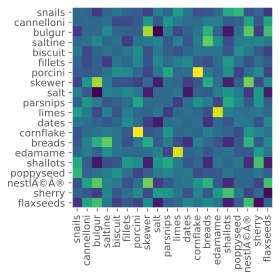

In [24]:
# adapted from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(small_sims)

ax.set_xticks(np.arange(len(small_vectors)))
ax.set_yticks(np.arange(len(small_vectors)))

ax.set_xticklabels(small_words)
ax.set_yticklabels(small_words)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.savefig('plot2.png', dpi=300)
plt.show()

In [25]:
np.savetxt('Data/words.txt', words, fmt='%s')
np.save('Data/vectors.npy', vectors)